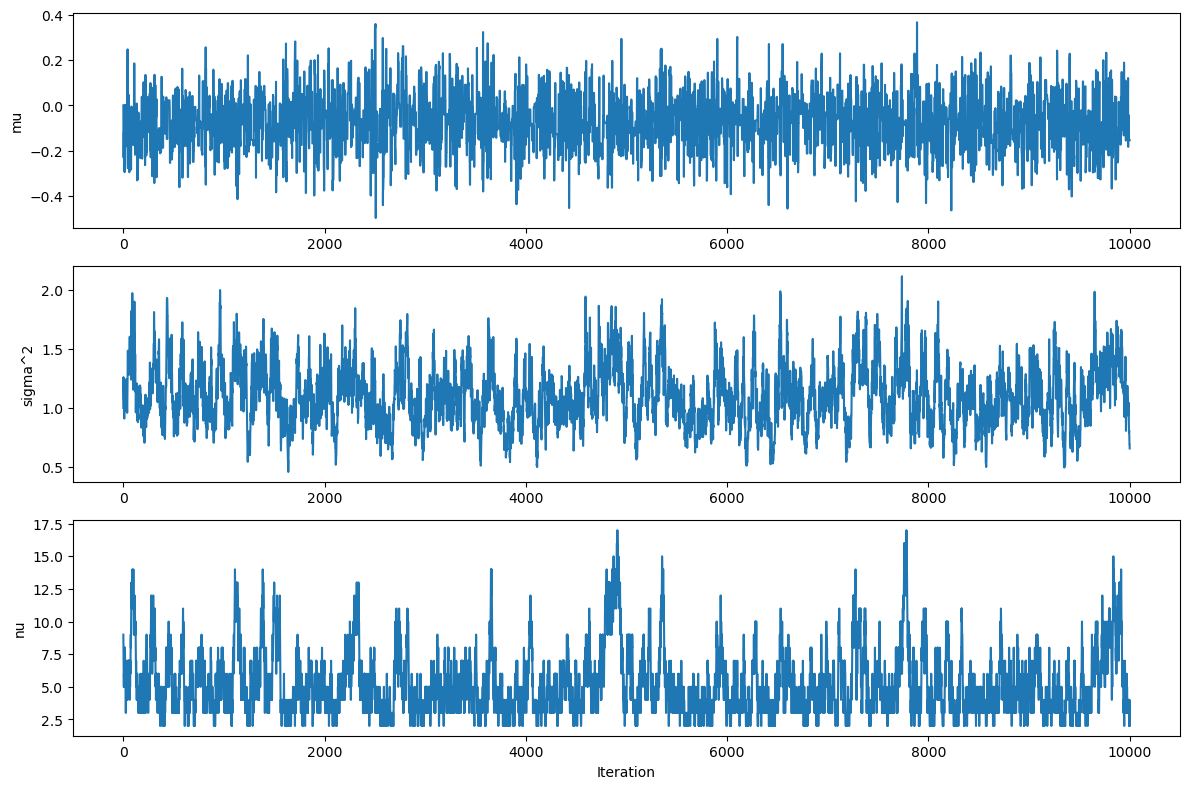

In [4]:
#Q1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

np.random.seed(123)

n = 100
true_mu = 0.0
true_sigma2 = 1
true_nu = 5

x = true_mu + np.sqrt(true_sigma2) * stats.t.rvs(df=true_nu, size=n)

mu0 = 0.0
tau0 = 1.0
sigma0 = 1.0

def log_posterior(mu, sigma2, nu, x, mu0, tau0, sigma0):
    if sigma2 <= 0 or nu < 1 or nu > 100:
        return -np.inf
    lp_nu = np.sum(gammaln((nu+1)/2) - gammaln(nu/2) - 0.5*np.log(nu*np.pi*sigma2) - 
                    ((nu+1)/2) * np.log(1 + ((x-mu)**2) / (nu*sigma2)))
    lp_mu = 0.5 * np.log(tau0 / (2*np.pi)) - (tau0/2) * (mu - mu0)**2
    lp_sigma2 = 0.5 * np.log(2 / (np.pi * sigma0**2)) - (sigma2**2) / (2 * sigma0**2)
    return lp_mu + lp_sigma2 + lp_nu

iters = 10000
mu_samples = np.zeros(iters)
sigma2_samples = np.zeros(iters)
nu_samples = np.zeros(iters, dtype=int)

mu_current = 0.0
sigma2_current = 1.0
nu_current = 10

log_post_current = log_posterior(mu_current, sigma2_current, nu_current, x, mu0, tau0, sigma0)

mu_step = 0.5
log_sigma2_step = 0.1

for i in range(iters):
    mu_proposal = mu_current + np.random.normal(0, mu_step)
    log_post_proposal = log_posterior(mu_proposal, sigma2_current, nu_current, x, mu0, tau0, sigma0)

    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        mu_current = mu_proposal
        log_post_current = log_post_proposal

    mu_samples[i] = mu_current

    log_sigma2_current = np.log(sigma2_current)
    log_sigma2_proposal = log_sigma2_current + np.random.normal(0, log_sigma2_step)
    sigma2_proposal = np.exp(log_sigma2_proposal)
    log_post_proposal = log_posterior(mu_current, sigma2_proposal, nu_current, x, mu0, tau0, sigma0)

    if np.log(np.random.rand()) < log_post_proposal - log_post_current + log_sigma2_proposal - log_sigma2_current:
        sigma2_current = sigma2_proposal
        log_post_current = log_post_proposal

    sigma2_samples[i] = sigma2_current

    nu_proposal = nu_current + np.random.choice([-1, 1])
    nu_proposal = max(1, min(nu_proposal, 100))

    log_post_proposal = log_posterior(mu_current, sigma2_current, nu_proposal, x, mu0, tau0, sigma0)

    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        nu_current = nu_proposal
        log_post_current = log_post_proposal

    nu_samples[i] = nu_current

plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(mu_samples)
plt.ylabel("mu")

plt.subplot(3,1,2)
plt.plot(sigma2_samples)
plt.ylabel("sigma^2")

plt.subplot(3,1,3)
plt.plot(nu_samples)
plt.ylabel("nu")
plt.xlabel("Iteration")

plt.tight_layout()
plt.show()


In [8]:
#Q2

import numpy as np
import pymc as pm
import arviz as az
from scipy import stats

np.random.seed(123)

sample_sizes = [50, 100, 500, 1000]
true_mu = 0.0
true_sigma = 1.0
true_nu = 5
results = {}

for n in sample_sizes:
    x = true_mu + true_sigma * stats.t.rvs(df=true_nu, size=n)

    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=5)
        sigma = pm.HalfNormal("sigma", sigma=5) 
        nu = pm.Gamma("nu", alpha=2, beta=0.1)
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        idata = pm.sample(2000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)
        results[n] = idata

for n in sample_sizes:
    print("Sample size:", n)
    print(az.summary(results[n].posterior, var_names=["nu"]))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 50
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  15.206  11.18   2.169   35.946      0.207    0.146    2509.0    2420.0   

    r_hat  
nu    1.0  
Sample size: 100
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.921  5.626   1.918   17.289      0.126    0.089    2189.0    2193.0   

    r_hat  
nu    1.0  
Sample size: 500
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.476  2.616   3.788   11.997      0.062    0.044    1938.0    1663.0   

    r_hat  
nu    1.0  
Sample size: 1000
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  5.374  0.959   3.712    7.086      0.021    0.015    2227.0    2278.0   

    r_hat  
nu    1.0  


The results demonstrate how sample size affects the inference of the degrees of freedom parameter ν in a Student's t-distribution using Bayesian estimation. When the sample size is small (n = 50), the posterior mean estimate of ν is significantly inflated at 15.206, with a wide 95% highest density interval (HDI) ranging from 2.169 to 35.946. This suggests that the model struggles to accurately infer ν due to the limited data, leading to high uncertainty and potential overestimation. As the sample size increases to n = 100, the mean estimate decreases to 7.921, and the HDI narrows, indicating improved precision. However, the uncertainty remains substantial, reflecting the challenge of estimating ν with moderate sample sizes. At n = 500, the posterior mean stabilizes further at 7.476, with a narrower HDI of (3.788, 11.997), demonstrating better convergence. When the sample size reaches n = 1000, the estimate becomes highly precise, centering around 5.374 with a significantly reduced uncertainty range of (3.712, 7.086), closely aligning with the true value ν = 5. These results confirm that larger sample sizes enable more accurate inference of ν, reducing estimation variance and posterior uncertainty. The high uncertainty in small samples suggests that the model struggles to distinguish between normal and heavy-tailed distributions, whereas larger samples provide stronger evidence for the true tail behavior, leading to more stable estimates.